In [1]:
from fastai.vision.all import *
import pandas as pd
import numpy as np

import torch
from torch import nn

from fastcore.meta import use_kwargs_dict

from fastai.callback.fp16 import to_fp16
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_one_cycle

from fastai.data.block import MultiCategoryBlock, DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import RandomSplitter, ColReader

from fastai.metrics import accuracy_multi, BaseLoss

from fastai.vision.augment import aug_transforms
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner

from torchvision.models import resnet34

In [ ]:
%%capture
!wget https://www.dropbox.com/s/u83ae1efaah2w9o/UCMercedLanduse.zip
!unzip UCMercedLanduse.zip

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
df = pd.read_csv("UCMerced/multilabels.txt", sep="\t")
df.head()

,IMAGE\LABEL,airplane,bare-soil,buildings,cars,chaparral,court,dock,field,grass,mobile-home,pavement,sand,sea,ship,tanks,trees,water
0,agricultural00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,agricultural01,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,agricultural02,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,agricultural03,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,agricultural04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [5]:
df = df.set_index('IMAGE\LABEL')

In [6]:
# s2 = pd.DataFrame(df.columns[np.where(df!=0)[1]])
# s2
strings = []
print(type(strings))
for index, row in df.iterrows():
  # row is a: <class 'pandas.core.series.Series'>
  output_string = []
  rowmax = row.max()
  # print(row.index[1])
  idx = np.where(row.values == rowmax)
  for i in np.nditer(idx):
    # print(row.index[i], end=' ')
    output_string.append(row.index[i])
  string = ' '.join(output_string)
  # print(string)
  strings.append(string)


<class 'list'>


In [7]:
df['tags'] = strings
df_new = df['tags'] 
df_new = df_new.reset_index()
df_new.head()

,IMAGE\LABEL,tags
0,agricultural00,field trees
1,agricultural01,field
2,agricultural02,field
3,agricultural03,field
4,agricultural04,trees


In [8]:
batch_tfms = aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [9]:
path = Path("UCMerced")
planet = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader(0, pref=f'{path}/images/', suff='.tif'),
                   splitter=RandomSplitter(),
                   get_y=ColReader(1, label_delim=' '),
                   batch_tfms = batch_tfms,
                   item_tfms=Resize(256))

In [10]:
dls = planet.dataloaders(df_new)

In [11]:
learn = cnn_learner(dls, models.resnet34, pretrained=True, metrics=[accuracy_multi])

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627

  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [12]:
learn.loss_func = BCEWithLogitsLossFlat()

SuggestedLRs(valley=0.0012022644514217973)

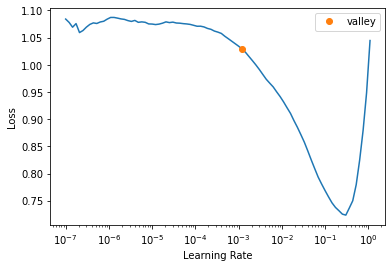

In [13]:
learn.lr_find()

In [14]:
lr = 1e-3
learn = learn.to_fp16()

In [15]:
learn.fit_one_cycle(5, slice(lr))


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.962209,0.653501,0.652521,00:07
1,0.799641,0.494285,0.757563,00:06
2,0.679823,0.414209,0.830252,00:07
3,0.596572,0.376984,0.861905,00:07
4,0.547606,0.376084,0.864566,00:07


In [16]:
learn.save('stage-1')


Path('models/stage-1.pth')

SuggestedLRs(valley=0.0004786300996784121)

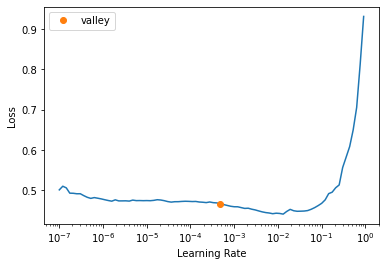

In [17]:
learn.unfreeze()
learn.lr_find()


In [18]:
learn.fit_one_cycle(5, slice(1e-4, lr/5))


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.477079,0.360553,0.874230,00:08
1,0.450813,0.317727,0.903361,00:08
2,0.421176,0.293480,0.917647,00:08
3,0.394628,0.281140,0.924930,00:08
4,0.381115,0.281158,0.925910,00:08


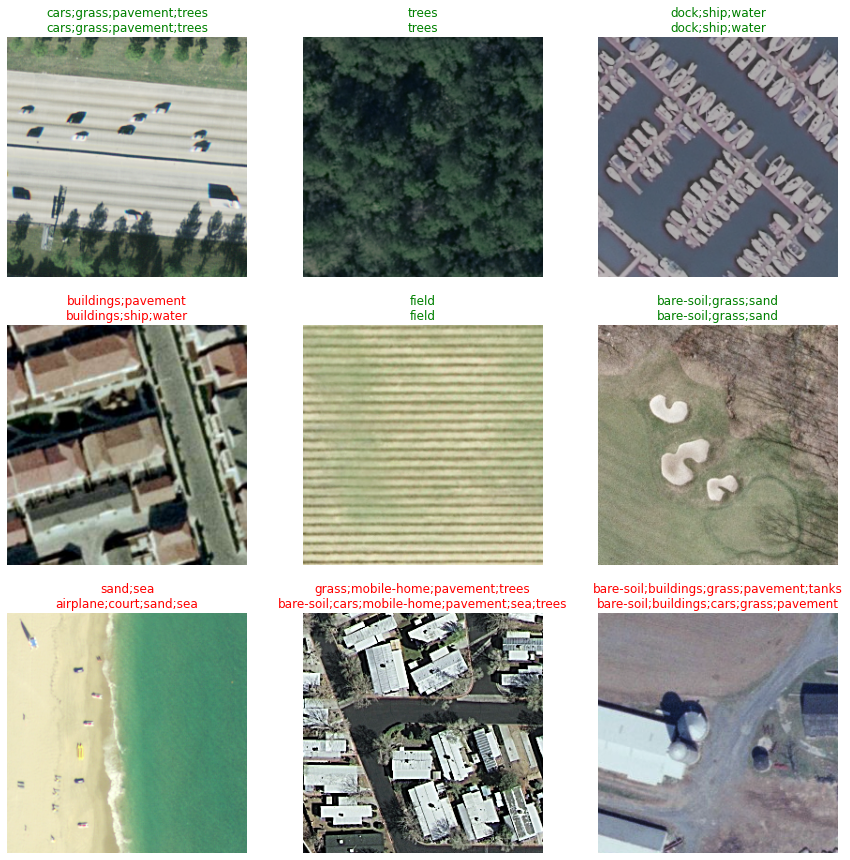

In [19]:
learn.show_results(figsize=(15,15))
